# Intelligent Systems - Individual Project Assessment
I aim to split the code into 3 sections:
1. Generating and analysing the datset
2. Developing my classification model
3. Training my model

In [123]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import Lambda
from torch.nn import functional as F
from scipy import io as sio

In [124]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device))
torch.set_default_device(device)

Using device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


## Dataset

### Data Augmentation
After inspection of the dataset, we have PIL images. Therefore, we will convert these to Tensors.

The values used for the normalisation of data were calculated from the ImageNet training datase

In [125]:
# We perform random transformations to better generalise the training dataset
train_transform = transforms.Compose([
    # transforms.Resize(256),
    # transforms.RandomCrop(224),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # I have chosen not to use RandomResizeCrop as it can remove large parts of the flowers
    transforms.ToTensor(),
    # These are the values I have calculated
    transforms.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.433, 0.382, 0.296],std=[0.259, 0.209, 0.221])
])

### Downloading and splitting the dataset

In [126]:
# I will download the data from PyTorch's website and use the appropriate data loader
train_dataset = datasets.Flowers102(
    root='flowers102',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)

valid_dataset = datasets.Flowers102(
    root='flowers102',
    split="val",
    download=True,
    transform=valid_transform,
    # target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_dataset = datasets.Flowers102(
    root='flowers102',
    split="test",
    download=True,
    transform=test_transform
)

# Get the targets and ids
image_labels = sio.loadmat("flowers102/flowers-102/imagelabels")
setids = sio.loadmat("flowers102/flowers-102/setid")
print(np.unique(image_labels['labels']).size)
train_ids = setids['trnid']

102


In [127]:
image, label = train_dataset[9]
label

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: torch.float32
Label: 1
Device tensor is stored on: cpu


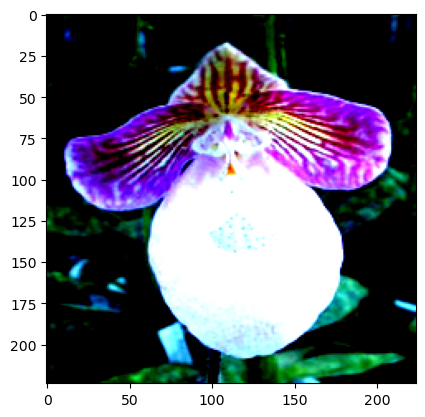

In [128]:
# look at the first training sample
image, label = train_dataset[15]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.dtype}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.permute(1, 2, 0))

## Model
I am first going to implement a very basic Convolutional Neural Network as these work well with images

In [129]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Identify a lot of features
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten(1)

        self.fc1 = nn.Linear(16 * 53 * 53, 600)
        self.fc2 = nn.Linear(600, 300)
        self.fc3 = nn.Linear(300, 102)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Batch is the 1st dimension, image dimensions are 2nd and 3rd
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

This architecture gave me an accuracy of 12% on the validation dataset. I will now attempt to use more channels and see if this improves the performance:

In [130]:
# Making my Convolutional Neural Network
class MyNN2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Feature Learning ###
        # 3 Input channels
        self.conv1 = nn.Conv2d(3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # ### Classification ###
        self.flatten = nn.Flatten()
        
        # After the 3rd convolutional layer, the filters will have dimensions 26x26
        # 128 x 28 x 28 features
        self.fc1 = nn.Linear(64*28*28, 3000)
        # Classify into one of the flower categories
        self.fc2 = nn.Linear(3000, 102)
                
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Flatten the tensor for fully connected layers        
        x = self.flatten(x)
        x = nn.Dropout(0.2)(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

Second Architecture was also poor (~22% accuracy). I will attempt to perform batch normalisation as well as using more convolutions per layer:

In [131]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        # Hold the residual, which will be added to the output
        residual = self.downsample(x) if self.downsample is not None else x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.conv2(out)
        out = self.batch_norm2(out)
        out += residual
        out = self.relu(out)
        return out

class MyNN3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        
        self.cb1 = ConvBlock(16, 16, 3, 1, 1)
        self.cb2 = ConvBlock(16, 32, 3, 1, 1)
        self.cb3 = ConvBlock(32, 64, 3, 1, 1)
        self.cb4 = ConvBlock(64, 128, 3, 1, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
            
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128*14*14, 512)
        self.fc2 = nn.Linear(512, 102)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        
        x = self.cb1(x)
        x = self.maxpool(x)
        x = self.cb2(x)
        x = self.maxpool(x)
        x = self.cb3(x)
        x = self.maxpool(x)
        x = self.cb4(x)
        x = self.maxpool(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [132]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Hold the residual, which will be added to the output
        residual = self.downsample(x) if self.downsample is not None else x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.conv2(out)
        out = self.batch_norm2(out)
        out += residual
        out = self.relu(out)
        return out


class MyNN4(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        self.cb1 = ConvBlock(16, 32, 3, 1, 1)
        self.cb2 = ConvBlock(32, 64, 3, 1, 1)
        self.cb3 = ConvBlock(64, 128, 3, 1, 1)
        self.cb4 = ConvBlock(128, 256, 3, 1, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256*14*14, 512)
        self.fc2 = nn.Linear(512, 102)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)

        x = self.cb1(x)
        x = self.maxpool(x)
        x = self.cb2(x)
        x = self.maxpool(x)
        x = self.cb3(x)
        x = self.maxpool(x)
        x = self.cb4(x)
        x = self.maxpool(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

This aims to be slightly simpler by creating a bottleneck.

In [133]:
class MyNN5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        
        self.fc1 = nn.Linear(16*224*224, 512)
        self.fc2 = nn.Linear(512, 102)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return x

In [134]:
class MyNN6(nn.Module):
    def __init__(self):
        super().__init__()
        # First, try to get the bigger picture (max pooling and larger filter)
        # output of sequence is 56x56x64
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32)
        )
        
        # Gradually build up features
        # output is 28x28x128
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        # output is 14x14x256
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(256*7*7, 8192),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        self.fc3 = nn.Linear(1024, 102)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [135]:
class MyNN7(nn.Module):
    def __init__(self):
        super().__init__()
        # First, try to get the bigger picture (max pooling and larger filter)
        # output of sequence is 56x56x64
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256)
        )
        
        # Gradually build up features
        # output is 28x28x128
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
        )
        # output is 14x14x256
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        # output is 7x7x32
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(32*7*7, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        self.fc3 = nn.Linear(512, 102)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [136]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, generator=torch.Generator(device=device), pin_memory=True)

In [137]:
model = MyNN6().to(device)

### Loss Function

In [138]:
# Targets don't have to be one-hot encoded
# Model output (criterion input) is expected to contain un-normalised inputs
criterion = nn.CrossEntropyLoss()

### Optimiser

In [139]:
# Momentum pushes the optimiser towards the strongest gradient over multiple steps.
optimiser = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

## Training

In [140]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        if batch % 10 == 9:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Batch {batch+1}:\nLoss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [141]:
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return val_loss

In [142]:
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=True, num_workers=2, generator=torch.Generator(device=device))

In [143]:
epochs = 50
start_time = time.time()
losses = []
best_loss = 1000000

print("[INFO] Training starting...")
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train(train_loader, model, criterion, optimiser)
    val_loss = validate(valid_loader, model, criterion)
    if val_loss < best_loss:
        best_loss = val_loss
        PATH = 'model6b.pth'
        torch.save(model.state_dict(), PATH)
        
finish_time = time.time()
print("[INFO] Testing and training completed.")
print(f"Elapsed time: {math.floor((finish_time-start_time)/60)}:{math.floor((finish_time-start_time)%60)}")

[INFO] Training starting...
Epoch 1
-------------------------------
Batch 10:
Loss: 4.633982  [  160/ 1020]
Batch 20:
Loss: 4.609569  [  320/ 1020]
Batch 30:
Loss: 4.619422  [  480/ 1020]
Batch 40:
Loss: 4.679860  [  640/ 1020]
Batch 50:
Loss: 4.568822  [  800/ 1020]
Batch 60:
Loss: 4.597676  [  960/ 1020]
Test Error: 
Accuracy: 1.8%, Avg loss: 4.597564 

Epoch 2
-------------------------------
Batch 10:
Loss: 4.665517  [  160/ 1020]
Batch 20:
Loss: 4.626249  [  320/ 1020]
Batch 30:
Loss: 4.583747  [  480/ 1020]
Batch 40:
Loss: 4.598061  [  640/ 1020]
Batch 50:
Loss: 4.615220  [  800/ 1020]
Batch 60:
Loss: 4.603179  [  960/ 1020]
Test Error: 
Accuracy: 3.9%, Avg loss: 4.543515 

Epoch 3
-------------------------------
Batch 10:
Loss: 4.577024  [  160/ 1020]
Batch 20:
Loss: 4.477584  [  320/ 1020]
Batch 30:
Loss: 4.568625  [  480/ 1020]
Batch 40:
Loss: 4.507636  [  640/ 1020]
Batch 50:
Loss: 4.398931  [  800/ 1020]
Batch 60:
Loss: 4.390266  [  960/ 1020]
Test Error: 
Accuracy: 5.9%, Avg

In [144]:
# Test on test dataset
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=2, generator=torch.Generator(device=device))

In [145]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        acc = .0
        for i, data in enumerate(test_loader):
            X = data[0].to(device)
            y = data[1].to(device)

            predicted = model(X)
            
            # Check each image's prediction
            acc += (predicted.argmax(1) == y).type(torch.float).sum().item()
    model.train()
    return acc/len(test_loader.dataset)

In [146]:
test_model = MyNN6().to(device)
test_model.load_state_dict(torch.load("model6b.pth"))
test_acc = test(test_model, test_loader)

In [147]:
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 36.14%
